# Bayesian Approach 
This notebook aims to help gain a better understanding of the Bayesian approach by defining a function that computes the possible parameter values with its variance and choosing random subsets of the possible parameter values to define a neural network model to model the function

### Import 
Import the functions necessary to define the neural network model and plot it as well as define the function that computes the possible parameter values with its variance

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Define True Function
Define the true function, which will be the function that the neural network model will be trying to model

In [2]:
def true_function(x):
    y = np.exp(np.sin(x*(2*3.1413)))
    return y

### Generate Data Points with Noise
With input values, compute the output value using the true function. After computing the output value, add noise to the output value to model the variance/uncertainty of the data point

In [3]:
def generate_data(n_data, sigma_y=0.3):
    # Generate x values from [0, 1]
    x = np.ones(n_data)
    for i in range(n_data):
        x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)

    # Evaluate the output value using the true function
    # Add noise to the output values
    y = np.ones(n_data)
    for i in range(n_data):
        y[i] = true_function(x[i])
        y[i] += np.random.normal(0, sigma_y, 1)
    return x,y

### Define Model and Data Point Plotting Function
Define a function that plots the neural network model as well as the data points and its uncertainty

In [4]:
def plot_function(x_func, y_func, x_data=None,y_data=None, x_model = None, y_model =None, sigma_func = None, sigma_model=None):

    fig,ax = plt.subplots()
    ax.plot(x_func, y_func, 'k-')
    if sigma_func is not None:
      ax.fill_between(x_func, y_func-2*sigma_func, y_func+2*sigma_func, color='lightgray')

    if x_data is not None:
        ax.plot(x_data, y_data, 'o', color='#d18362')

    if x_model is not None:
        ax.plot(x_model, y_model, '-', color='#7fe7de')

    if sigma_model is not None:
      ax.fill_between(x_model, y_model-2*sigma_model, y_model+2*sigma_model, color='lightgray')

    ax.set_xlim(0,1)
    ax.set_xlabel('Input, x')
    ax.set_ylabel('Output, y')
    plt.show()

### Compute True Function
Compute the output of the true function by using the input values (x_func)

In [5]:
x_func = np.linspace(0, 1.0, 100)
y_func = true_function(x_func)

### Compute Data Points
Compute the data points of the true function and add variance to the data points

In [6]:
sigma_func = 0.3
n_data = 15
x_data,y_data = generate_data(n_data, sigma_func)

/var/folders/hd/f_gk36z51lj__phqtmgrmv8w0000gn/T/ipykernel_9815/2043700207.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)
/var/folders/hd/f_gk36z51lj__phqtmgrmv8w0000gn/T/ipykernel_9815/2043700207.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] += np.random.normal(0, sigma_y, 1)


### Plot True Function and Data Points
Plot the true function as well as the data points and their variance

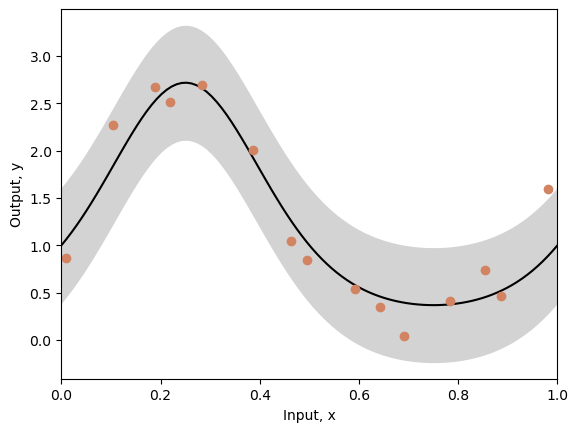

In [7]:
plot_function(x_func, y_func, x_data, y_data, sigma_func=sigma_func)

### Define Neural Network Model

In [8]:
def network(x, beta, omega):
    # Retrieve number of hidden units
    n_hidden = omega.shape[0]

    y = np.zeros_like(x)
    for c_hidden in range(n_hidden):
        # Evaluate activations based on shifted lines 
        line_vals =  x  - c_hidden/n_hidden
        h =  line_vals * (line_vals > 0)
        # Compute the weighted activations and sum to find the output value
        y = y + omega[c_hidden] * h

    # Add bias, beta (parameters)
    y = y + beta

    return y

### Define Hidden Unit Computation Function
Define a function that computes the value of each hidden unit in a neural network model

In [9]:
def compute_H(x_data, n_hidden):
  psi1 = np.ones((n_hidden+1,1))
  psi0 = np.linspace(0.0, 1.0, num=n_hidden, endpoint=False) * -1

  n_data = x_data.size
  # Compute the hidden variables
  H = np.ones((n_hidden+1, n_data))
  for i in range(n_hidden):
    for j in range(n_data):
      # Compute preactivation
      H[i,j] = psi1[i] * x_data[j]+psi0[i]
      # Apply ReLU to get activation
      if H[i,j] < 0:
        H[i,j] = 0

  return H

## Bayesian Approach (posterior distribution formula for Bayesian linear regression)
Define the posterior distribution formula for Bayesian linear regression, which represents the distribution of the possible parameter values for a neural network model

$$
Pr(\phi \mid \{x_i, y_i\}) 
= 
\mathrm{Norm}_{\phi}
\left[
\underbrace{
\frac{1}{\sigma^{2}}
\left( 
\frac{1}{\sigma^{2}}HH^{T} + \frac{1}{\sigma_{p}^{2}} I 
\right)^{-1} 
Hy
}_{\text{Posterior Mean}},
\quad
\underbrace{
\left( 
\frac{1}{\sigma^{2}}HH^{T} + \frac{1}{\sigma_{p}^{2}} I 
\right)^{-1}
}_{\text{Posterior Covariance}}
\right].
$$

# Define Posterior Mean and Posterior Covariance Function
Define a function that computes the posetrior mean matrix and the posterior covariance matrix

In [10]:
def compute_param_mean_covar(x_data, y_data, n_hidden, sigma_sq, sigma_p_sq):
  # Retrieve the matrix containing the hidden variables
  H = compute_H(x_data, n_hidden) 

  # Compute the covariance matrix
  phi_covar = np.linalg.inv((1/sigma_sq)*np.matmul(H, H.T) + (1/sigma_p_sq)*np.identity(H.shape[0]))

  # Compute the mean matrix
  phi_mean = (1/sigma_sq)*np.matmul(phi_covar, np.matmul(H, y_data))

  return phi_mean, phi_covar

### Define Parameters
Define the parameters for a neural network model

In [11]:
n_hidden = 5
sigma_sq = sigma_func * sigma_func
sigma_p_sq = 1000

### Compute Posterior Mean and Posterior Covariance

In [12]:
phi_mean, phi_covar = compute_param_mean_covar(x_data, y_data, n_hidden, sigma_sq, sigma_p_sq)

/var/folders/hd/f_gk36z51lj__phqtmgrmv8w0000gn/T/ipykernel_9815/1457625065.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H[i,j] = psi1[i] * x_data[j]+psi0[i]


### Plot Mean Model
Plot the neural network model using the posterior mean parameter values computed by the function

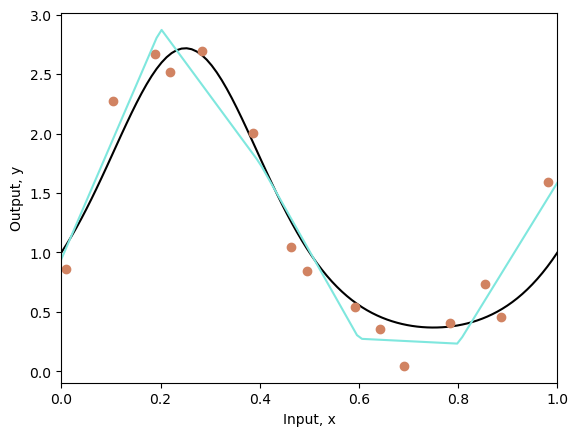

In [13]:
x_model = x_func
y_model_mean = network(x_model, phi_mean[-1], phi_mean[0:n_hidden])
plot_function(x_func, y_func, x_data, y_data, x_model, y_model_mean)

### Bayesian Approach
Undergo the Bayesian approach by choosing two random subsets of the possible parameter values to define a neural network model to model the function

In [14]:
samples = np.random.multivariate_normal(phi_mean, phi_covar, size=2)
phi_sample1 = samples[0]
phi_sample2 = samples[1]

### Compute Neural Network with Chosen Parameters
Compute the neural network with the two random subsets of possible parameter values

In [15]:
y_model_sample1 = network(x_model, phi_sample1[-1], phi_sample1[0:n_hidden])
y_model_sample2 = network(x_model, phi_sample2[-1], phi_sample2[0:n_hidden])

### Plot Resulting Neural Network Model

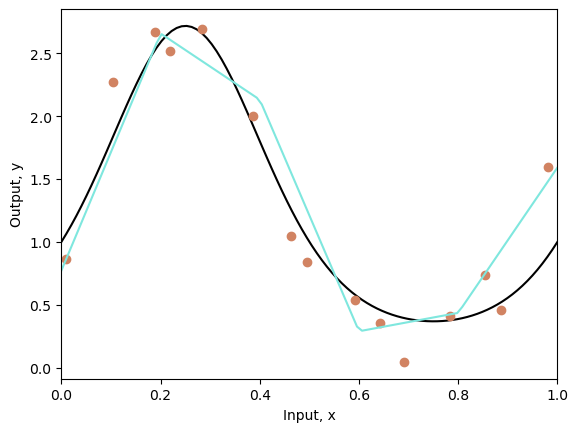

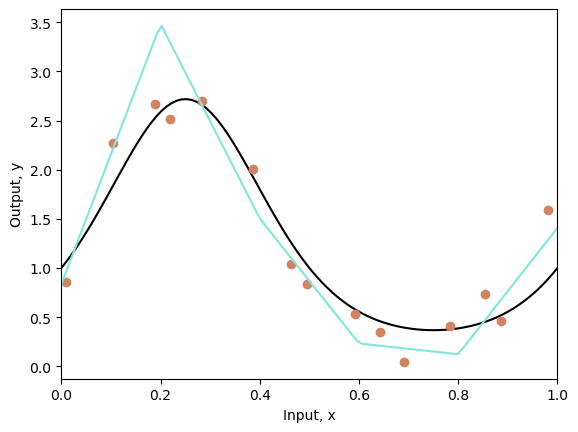

In [16]:
plot_function(x_func, y_func, x_data, y_data, x_model, y_model_sample1)
plot_function(x_func, y_func, x_data, y_data, x_model, y_model_sample2)

## Bayesian Approach (Bayesian linear regression predictive distribution)
Using the distribution of possible parameter values for the neural network model, compute the possible output values as well as the uncertainty of each output value through the equation:

$= \mathrm{Norm}_{y^*}\!\left[
\underbrace{
\frac{1}{\sigma^2}\,[h^{*T}, 1]
\left( \frac{1}{\sigma^{2}} HH^{T} + \frac{1}{\sigma_{p}^{2}} I \right)^{-1}
Hy
}_{\text{mean}},
\;
\underbrace{
[h^{*T}, 1]
\left( \frac{1}{\sigma^{2}} HH^{T} + \frac{1}{\sigma_{p}^{2}} I \right)^{-1}
\begin{bmatrix} h^{*} \\ 1 \end{bmatrix}
}_{\text{variance}}
\right].$

### Predict Mean and Variance of Predicited Output
Using the defined equation above, compute a function that returns the possible output values and its uncertainty (variance). Take the mean of the possible output values to compute the expected value of the output value

In [17]:
def inference(x_star, x_data, y_data, sigma_sq, sigma_p_sq, n_hidden):
  # Compute hidden variables
  h_star = compute_H(x_star, n_hidden)
  H = compute_H(x_data, n_hidden)

  # Compute mean and variance of the predicted output value
  h_star_flat = h_star.reshape(-1)  
  main_term = np.linalg.inv((1/sigma_sq)*np.matmul(H, H.T) + (1/sigma_p_sq)*np.identity(H.shape[0]))
  y_star_mean = (1/sigma_sq)*np.matmul(np.hstack([h_star_flat]), np.matmul(main_term, np.matmul(H, y_data)))
  y_star_var =  np.matmul(np.hstack([h_star_flat]), np.matmul(main_term, np.hstack([h_star_flat])))

  return y_star_mean, y_star_var

### Define Output Array Structure
Define an array structure that stores the output of the neural network model

In [18]:
x_model = x_func
y_model = np.zeros_like(x_model)
y_model_std = np.zeros_like(x_model)

### Compute Mean and Variance of Predicited Output
Compute the mean and variance of the predicited output for each input value of the model

In [19]:
for c_model in range(len(x_model)):
  y_star_mean, y_star_var = inference(x_model[c_model]*np.ones((1,1)), x_data, y_data, sigma_sq, sigma_p_sq, n_hidden)
  y_model[c_model] = y_star_mean
  y_model_std[c_model] = np.sqrt(y_star_var)

/var/folders/hd/f_gk36z51lj__phqtmgrmv8w0000gn/T/ipykernel_9815/1457625065.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H[i,j] = psi1[i] * x_data[j]+psi0[i]


### Plot Model
Use the computed mean and variance of the predicited output to plot a neural network model

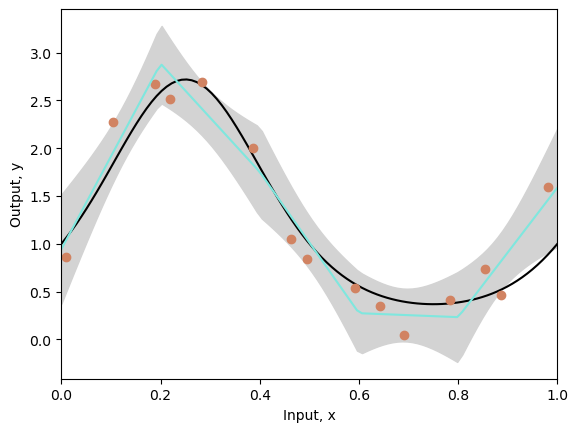

In [20]:
plot_function(x_func, y_func, x_data, y_data, x_model, y_model, sigma_model=y_model_std)